# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

seed = 40
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data

In [ ]:
data = np.load("/kaggle/input/dataset/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
def calculate_class_proportions(label, num_classes):
    """
    Calculate the proportion of each class in a semantic segmentation label image.
    Args:
        label (numpy array): Label image (height, width).
        num_classes (int): Total number of classes.
    Returns:
        dict: Dictionary with class indices as keys and proportions as values.
    """
    total_pixels = label.size  # Total number of pixels in the image
    proportions = {}

    for class_id in range(num_classes):
        class_pixels = np.sum(label == class_id)  # Count pixels of the current class
        proportions[class_id] = class_pixels / total_pixels  # Proportion of this class

    return proportions

# Calculate aliens-images class proportions
num_classes = 5  # Background, Soil, Bedrock, Sand, Big Rock
example_label = y_train[1092]

aliens_proportions = calculate_class_proportions(example_label, num_classes)
print("Class Proportions:", aliens_proportions)

X_train_filtered = []
y_train_filtered = []
X_outliers = []
y_outliers = []
# Filtra i campioni
filtered_indices = []
for i, label in enumerate(y_train):
    proportions = calculate_class_proportions(label, num_classes=5)
    if proportions == aliens_proportions:  # Campioni da rimuovere
        X_outliers.append(X_train[i])
        y_outliers.append(y_train[i])
    else:  # Campioni validi
        X_train_filtered.append(X_train[i])
        y_train_filtered.append(y_train[i])



print(f"Numero di campioni originali: {len(X_train)}")
print(f"Numero di campioni filtrati: {len(X_train_filtered)}")

Class Proportions: {0: 0.530517578125, 1: 0.192626953125, 2: 0.0966796875, 3: 0.18017578125, 4: 0.0}
Numero di campioni originali: 2615
Numero di campioni filtrati: 2505


In [ ]:
X_train = np.array(X_train_filtered)
y_train = np.array(y_train_filtered)

print(f"Shape di X_train_filtered: {X_train.shape}")
print(f"Shape di y_train_filtered: {y_train.shape}")

Shape di X_train_filtered: (2505, 64, 128)
Shape di y_train_filtered: (2505, 64, 128)


In [ ]:
num_classes = 5


class_pixel_counts = np.zeros(num_classes, dtype=np.int64)

for mask in y_train:
    unique, counts = np.unique(mask, return_counts=True)
    for cls, count in zip(unique, counts):
        if 0 <= cls < num_classes:
            class_pixel_counts[int(cls)] += count

total_pixels = np.sum(class_pixel_counts)  # Total pixels
background_pixels = class_pixel_counts[0]  # Background pixels
non_background_pixels = total_pixels - background_pixels

percentages = (class_pixel_counts / total_pixels) * 100

background_vs_others = (background_pixels / non_background_pixels) * 100

for cls, percentage in enumerate(percentages):
    print(f"Classe {cls}: {percentage:.2f}%")

print(f"\nPercentuale di background rispetto a tutte le altre classi: {background_vs_others:.2f}%")

Classe 0: 24.31%
Classe 1: 33.90%
Classe 2: 23.28%
Classe 3: 18.38%
Classe 4: 0.13%

Percentuale di background rispetto a tutte le altre classi: 32.12%


In [ ]:
only_background = [i for i, mask in enumerate(y_train) if np.all(mask == 0)]

print(f"Number of images with only background: {len(only_background)}")

Number of images with only background: 7


In [ ]:
# Background threshold
background_threshold = 0.8  # 80%

X_train_filtered = []
y_train_filtered = []

for img, mask in zip(X_train, y_train):

    total_pixels = mask.size
    background_pixels = np.sum(mask == 0)
    background_ratio = background_pixels / total_pixels

    if background_ratio < background_threshold:
        X_train_filtered.append(img)
        y_train_filtered.append(mask)

X_train_filtered = np.array(X_train_filtered)
y_train_filtered = np.array(y_train_filtered)

print(f"Original dataset size: {len(X_train)}")
print(f"Filtered dataset size: {len(X_train_filtered)}")

Original dataset size: 2505
Filtered dataset size: 2248


In [ ]:
print(f"Shape di X_train_filtered: {X_train_filtered.shape}")
print(f"Shape di y_train_filtered: {y_train_filtered.shape}")

Shape di X_train_filtered: (2248, 64, 128)
Shape di y_train_filtered: (2248, 64, 128)


## Augmentation

In [ ]:
def cutmix(image1, mask1, image2, mask2):


    if len(image1.shape) == 3:  # (H, W, 1)
        image1 = np.squeeze(image1, axis=-1)
        image2 = np.squeeze(image2, axis=-1)

    h, w = image1.shape

    cut_x = np.random.randint(0, w)
    cut_y = np.random.randint(0, h)
    cut_w = np.random.randint(w // 4, w // 2)
    cut_h = np.random.randint(h // 4, h // 2)

    x1 = np.clip(cut_x - cut_w // 2, 0, w)
    x2 = np.clip(cut_x + cut_w // 2, 0, w)
    y1 = np.clip(cut_y - cut_h // 2, 0, h)
    y2 = np.clip(cut_y + cut_h // 2, 0, h)

    mixed_image = image1.copy()
    mixed_image[y1:y2, x1:x2] = image2[y1:y2, x1:x2]

    mixed_mask = mask1.copy()
    mixed_mask[y1:y2, x1:x2] = mask2[y1:y2, x1:x2]

    mixed_image = np.expand_dims(mixed_image, axis=-1)  # (H, W, 1)

    return mixed_image, mixed_mask

In [ ]:
@tf.function
def augment_image_and_mask(image, mask):

    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
    if len(mask.shape) == 2:
        mask = tf.expand_dims(mask, axis=-1)

    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)

    return image, mask

## 🛠️ Train and Save the Model

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 300

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train_filtered[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

y_train = y_train_filtered

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def se_block(input_tensor, ratio=8):
    channels = input_tensor.shape[-1]
    # Squeeze: Global average pooling
    se = tfkl.GlobalAveragePooling2D()(input_tensor)
    se = tfkl.Dense(channels // ratio, activation='relu')(se)
    se = tfkl.Dense(channels, activation='sigmoid')(se)
    # Excite: Scale the input tensor
    se = tfkl.Multiply()([input_tensor, se])  # Element-wise multiplication
    return se

In [ ]:


def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')
    bottleneck = se_block(bottleneck)


    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])

    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)


    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_8   │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_9   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckconv1   │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckbn1     │ (None, 16, 32,  │       512 │ bottleneckcon… │   Y 

 Total params: 477,909 (1.82 MB)

 Trainable params: 476,629 (1.82 MB)

 Non-trainable params: 1,280 (5.00 KB)

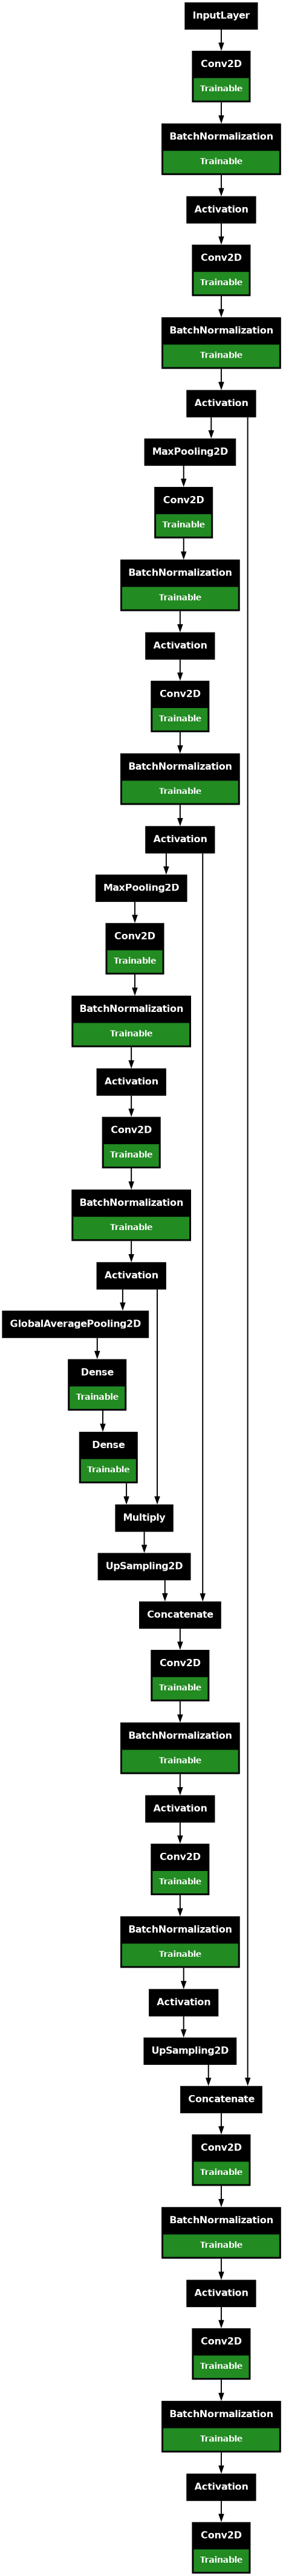

In [ ]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
# Define custom Mean Intersection Over Union metric
@tf.keras.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, **kwargs):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, **kwargs)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, frequency=5):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            idx = np.random.randint(0, len(self.X_train))
            image = self.X_train[idx]
            label = self.y_train[idx]

            image = np.expand_dims(image, axis=0)

            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()[0]

            class_colors = ['black', 'brown', 'gray', 'yellow', 'red']
            num_classes = len(class_colors)
            colormap = ListedColormap(class_colors)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0, :, :, 0], cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(label, cmap=colormap, vmin=0, vmax=num_classes - 1)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred, cmap=colormap, vmin=0, vmax=num_classes - 1)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

validation_fraction = 0.2

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=validation_fraction, random_state=seed
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 1798
Validation set size: 450


In [ ]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (1798, 64, 128, 1)
Shape of y_train: (1798, 64, 128)


Original dataset size: 1798
Augmented dataset size: 5394


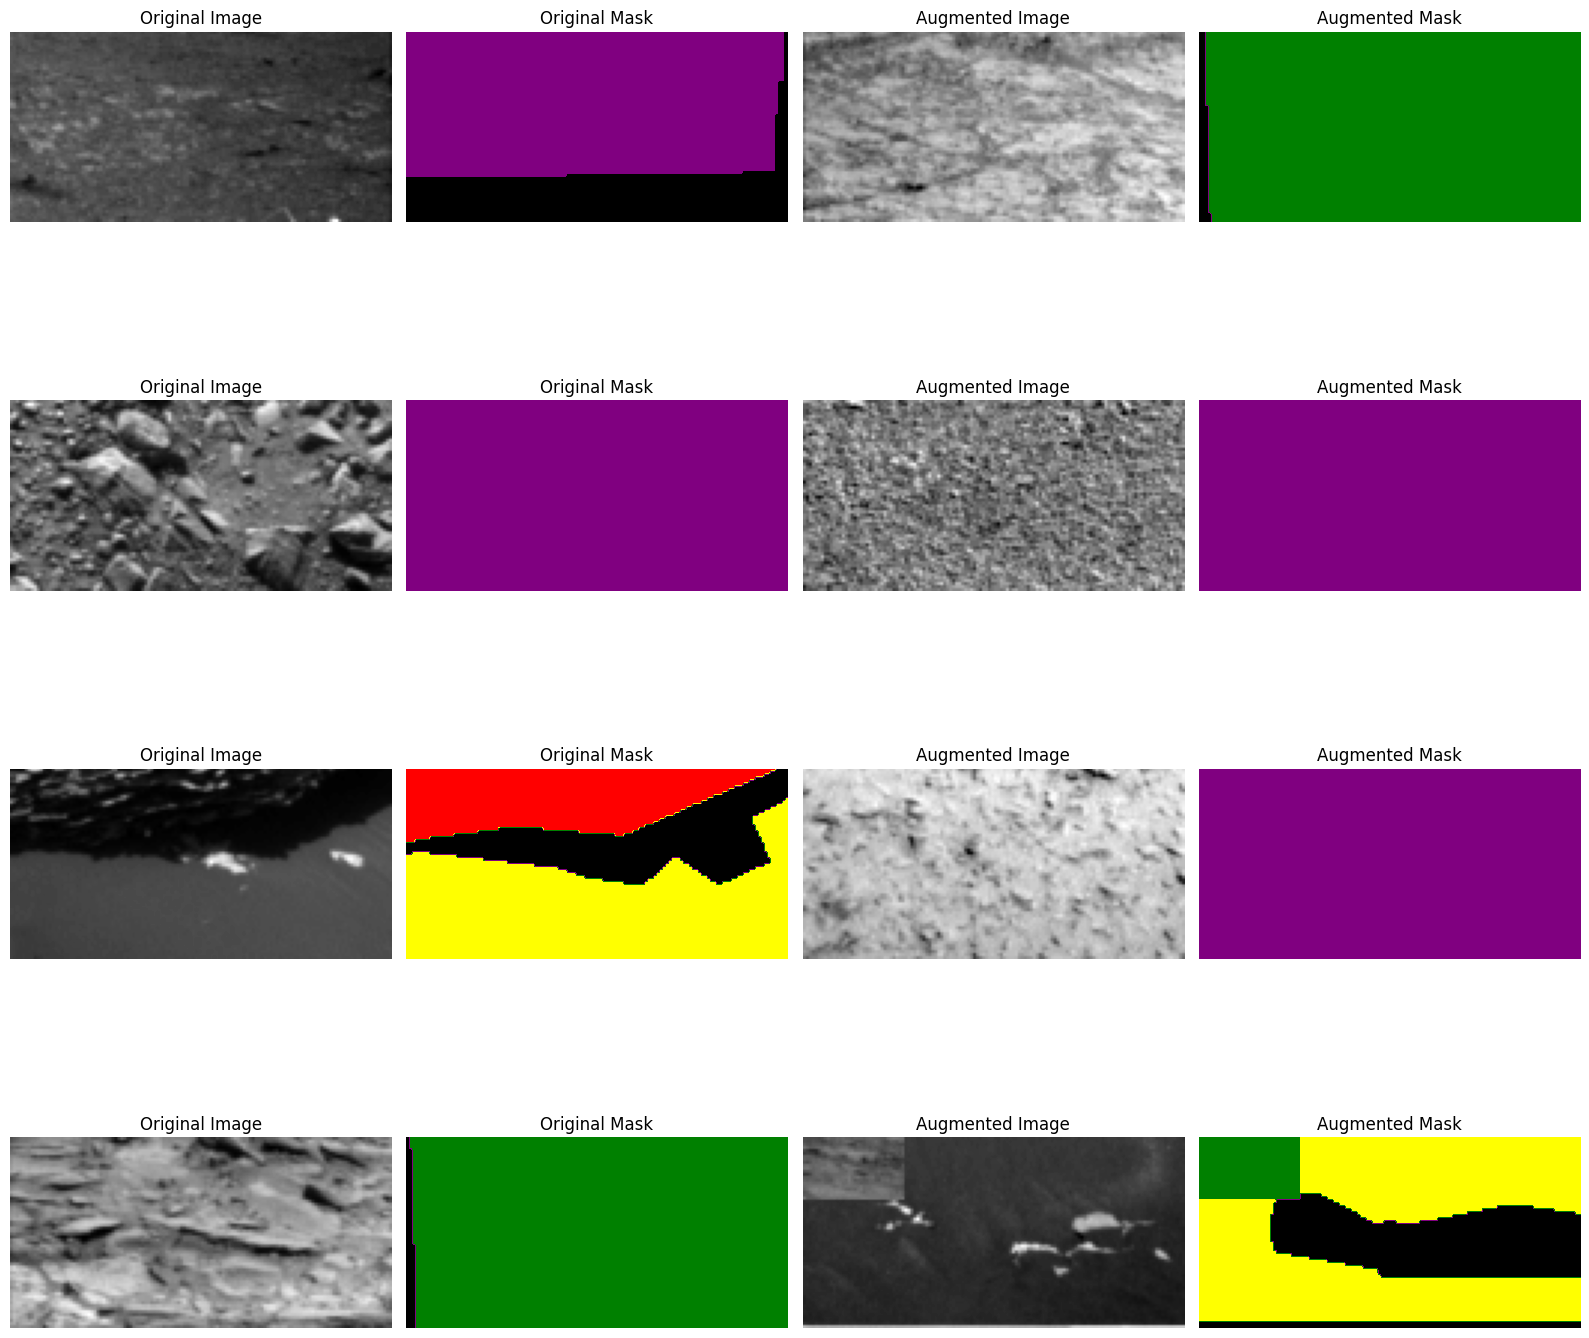

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def augment_training_set(X_train, y_train, num_augmentations):

    augmented_X = []
    augmented_y = []

    for _ in range(num_augmentations):
        # Random select two images
        idx1, idx2 = np.random.choice(len(X_train), size=2, replace=False)
        img1, mask1 = X_train[idx1], y_train[idx1]
        img2, mask2 = X_train[idx2], y_train[idx2]

        # Apply cutmix
        mixed_image, mixed_mask = cutmix(img1, mask1, img2, mask2)

        # Apply flip
        flipped_image, flipped_mask = augment_image_and_mask(
            tf.convert_to_tensor(mixed_image, dtype=tf.float32),
            tf.convert_to_tensor(mixed_mask, dtype=tf.int32)
        )

        augmented_X.append(flipped_image.numpy())
        augmented_y.append(flipped_mask.numpy())

    augmented_y = [np.squeeze(mask, axis=-1) if len(mask.shape) == 3 else mask for mask in augmented_y]

    X_train_augmented = np.concatenate([X_train] + [np.array(augmented_X)], axis=0)
    y_train_augmented = np.concatenate([y_train] + [np.array(augmented_y)], axis=0)

    return X_train_augmented, y_train_augmented

def visualize_augmentation_examples(X_train, y_train, X_augmented, y_augmented, num_examples=4):

    cmap = ListedColormap(['black', 'purple', 'green', 'yellow', 'red'])

    fig, axs = plt.subplots(num_examples, 4, figsize=(16, 4 * num_examples))

    for i in range(num_examples):
        idx = np.random.randint(0, len(X_train))
        idx_aug = np.random.randint(0, len(X_augmented))

        axs[i, 0].imshow(X_train[idx, :, :, 0], cmap="gray")
        axs[i, 0].set_title("Original Image")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(y_train[idx], cmap=cmap, vmin=0, vmax=4)
        axs[i, 1].set_title("Original Mask")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(X_augmented[idx_aug, :, :, 0], cmap="gray")
        axs[i, 2].set_title("Augmented Image")
        axs[i, 2].axis("off")

        axs[i, 3].imshow(y_augmented[idx_aug], cmap=cmap, vmin=0, vmax=4)
        axs[i, 3].set_title("Augmented Mask")
        axs[i, 3].axis("off")

    plt.tight_layout()
    plt.show()


num_augmentations = 3596
X_train_augmented, y_train_augmented = augment_training_set(X_train, y_train, num_augmentations)


print(f"Original dataset size: {X_train.shape[0]}")
print(f"Augmented dataset size: {X_train_augmented.shape[0]}")


visualize_augmentation_examples(X_train, y_train, X_train_augmented, y_train_augmented, num_examples=4)

In [ ]:
from tensorflow.keras.saving import register_keras_serializable

def compute_class_weights(y_train, num_classes=5):
    """
    Compute class weights for segmentation masks.

    Args:
        y_train (list of numpy arrays): List of segmentation masks.
        num_classes (int): Total number of classes.

    Returns:
        numpy array: Array of class weights.
    """
    class_pixel_counts = np.zeros(num_classes, dtype=np.float64)
    total_pixels = 0

    # Count the total number of pixels for each class
    for mask in y_train:
        for class_id in range(num_classes):
            class_pixel_counts[class_id] += np.sum(mask == class_id)
        total_pixels += mask.size

    # Avoid division by zero by adding a small epsilon to counts
    epsilon = 1e-6
    class_weights = total_pixels / (class_pixel_counts + epsilon)

    # Normalize the weights so that the average is 1
    class_weights /= np.mean(class_weights)

    return class_weights

# Compute class weights for the filtered training set
class_weights = compute_class_weights(y_train_augmented, num_classes=5)

# Print the computed class weights
print(f"Computed class weights: {class_weights}")

@register_keras_serializable()
class WeightedCategoricalCrossentropy:
    def __init__(self, class_weights):
        """
        A custom loss function for weighted categorical cross-entropy.

        Args:
            class_weights (numpy array or list): Array of weights for each class.
        """
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)

    def __call__(self, y_true, y_pred):
        """
        Compute the weighted categorical cross-entropy loss.

        Args:
            y_true (tensor): Ground truth labels, shape (batch_size, height, width).
            y_pred (tensor): Predicted logits, shape (batch_size, height, width, num_classes).

        Returns:
            tensor: Weighted categorical cross-entropy loss.
        """
        # One-hot encode y_true
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(self.class_weights))
        # Apply softmax to y_pred
        y_pred_softmax = tf.nn.softmax(y_pred, axis=-1)
        # Compute pixel-wise cross-entropy
        cross_entropy = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred_softmax + 1e-6), axis=-1)
        # Apply class weights
        weights = tf.reduce_sum(y_true_one_hot * self.class_weights, axis=-1)
        weighted_cross_entropy = weights * cross_entropy
        return tf.reduce_mean(weighted_cross_entropy)

    def get_config(self):
        """
        Returns the configuration of the loss function for serialization.
        """
        return {'class_weights': self.class_weights.numpy().tolist()}

    @classmethod
    def from_config(cls, config):
        """
        Reconstructs the class instance from the configuration dictionary.
        """
        return cls(config['class_weights'])

loss_function = WeightedCategoricalCrossentropy(class_weights)
# Compile the model
print("Compiling model...")
model.compile(
    loss=loss_function,
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)
print("Model compiled!")


Computed class weights: [0.03658464 0.01619876 0.02371355 0.03086922 4.89263383]
Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_val, y_val)

Epoch 1/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3496 - loss: 0.0442 - mean_intersection_over_union_3: 0.1717

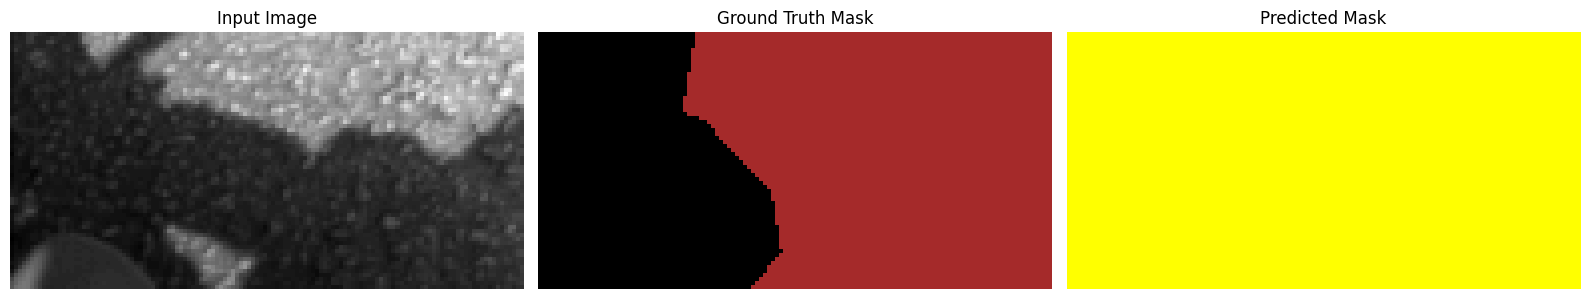

169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.3499 - loss: 0.0442 - mean_intersection_over_union_3: 0.1719 - val_accuracy: 0.2093 - val_loss: 0.0555 - val_mean_intersection_over_union_3: 0.0632
Epoch 2/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.4934 - loss: 0.0410 - mean_intersection_over_union_3: 0.2659 - val_accuracy: 0.2094 - val_loss: 0.0555 - val_mean_intersection_over_union_3: 0.0632
Epoch 3/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.5487 - loss: 0.0397 - mean_intersection_over_union_3: 0.3067 - val_accuracy: 0.2474 - val_loss: 0.0540 - val_mean_intersection_over_union_3: 0.0800
Epoch 4/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.5759 - loss: 0.0390 - mean_intersection_over_union_3: 0.3308 - val_accuracy: 0.3536 - val_loss: 0.0499 - val_mean_intersection_over_union_3: 0.1467
Epoch 5/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6073 - loss: 0.0381 - mean_intersection_over_union_3: 0.3493 - val_acc

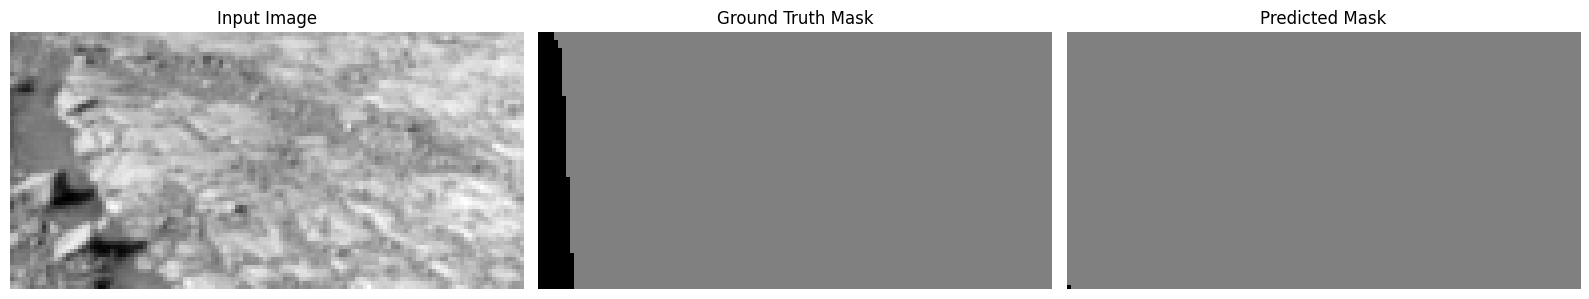

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6277 - loss: 0.0376 - mean_intersection_over_union_3: 0.3633 - val_accuracy: 0.4659 - val_loss: 0.0494 - val_mean_intersection_over_union_3: 0.2323
Epoch 7/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6309 - loss: 0.0375 - mean_intersection_over_union_3: 0.3675 - val_accuracy: 0.3571 - val_loss: 0.0471 - val_mean_intersection_over_union_3: 0.1770
Epoch 8/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6059 - loss: 0.0377 - mean_intersection_over_union_3: 0.3504 - val_accuracy: 0.4591 - val_loss: 0.0455 - val_mean_intersection_over_union_3: 0.2351
Epoch 9/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6294 - loss: 0.0372 - mean_intersection_over_union_3: 0.3655 - val_accuracy: 0.4028 - val_loss: 0.0483 - val_mean_intersection_over_union_3: 0.1839
Epoch 10/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6016 - loss: 0.0380 - mean_intersection_over_union_3: 0.3446 - val_acc

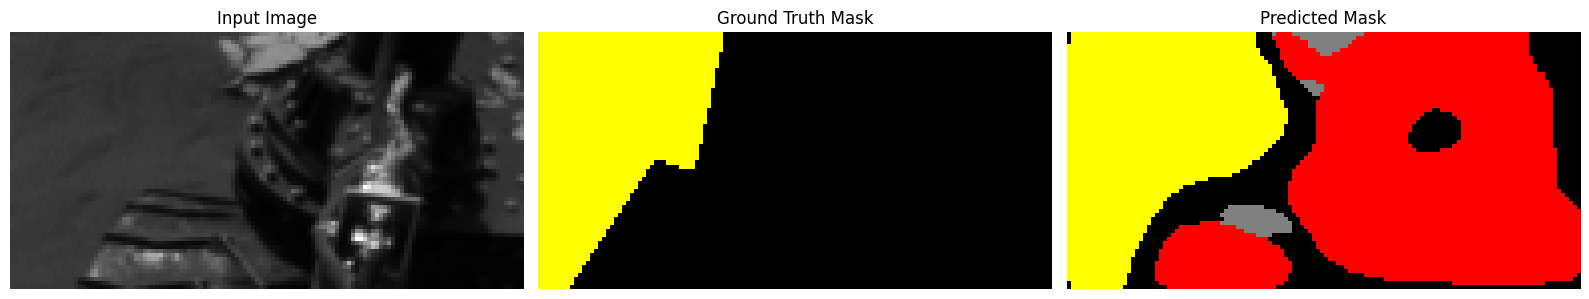

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6679 - loss: 0.0364 - mean_intersection_over_union_3: 0.3943 - val_accuracy: 0.4590 - val_loss: 0.0462 - val_mean_intersection_over_union_3: 0.2243
Epoch 12/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.6618 - loss: 0.0364 - mean_intersection_over_union_3: 0.3850 - val_accuracy: 0.5159 - val_loss: 0.0441 - val_mean_intersection_over_union_3: 0.2686
Epoch 13/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6869 - loss: 0.0358 - mean_intersection_over_union_3: 0.4075 - val_accuracy: 0.6965 - val_loss: 0.0423 - val_mean_intersection_over_union_3: 0.4149
Epoch 14/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6642 - loss: 0.0369 - mean_intersection_over_union_3: 0.3898 - val_accuracy: 0.6579 - val_loss: 0.0451 - val_mean_intersection_over_union_3: 0.3886
Epoch 15/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6921 - loss: 0.0358 - mean_intersection_over_union_3: 0.4131 - val_

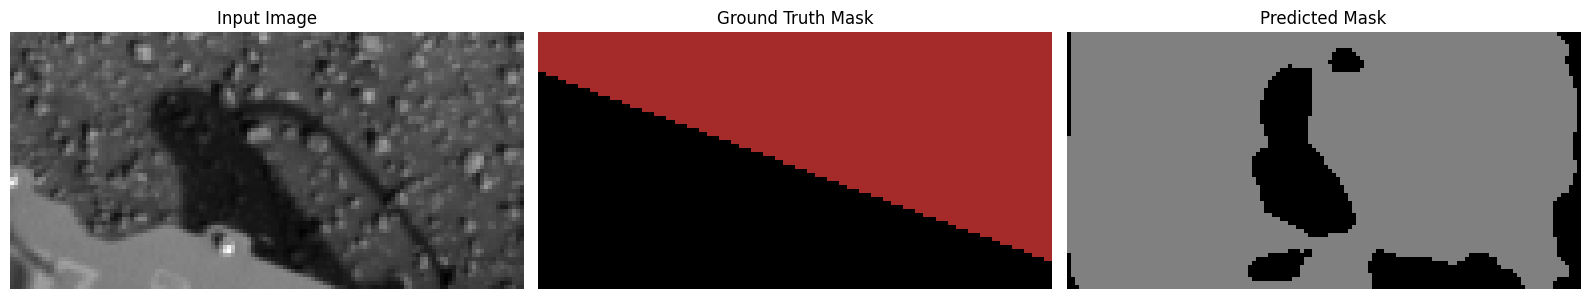

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6839 - loss: 0.0359 - mean_intersection_over_union_3: 0.4063 - val_accuracy: 0.6457 - val_loss: 0.0429 - val_mean_intersection_over_union_3: 0.3764
Epoch 17/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7136 - loss: 0.0351 - mean_intersection_over_union_3: 0.4291 - val_accuracy: 0.7029 - val_loss: 0.0428 - val_mean_intersection_over_union_3: 0.4315
Epoch 18/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7083 - loss: 0.0352 - mean_intersection_over_union_3: 0.4239 - val_accuracy: 0.6862 - val_loss: 0.0438 - val_mean_intersection_over_union_3: 0.4141
Epoch 19/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6375 - loss: 0.0373 - mean_intersection_over_union_3: 0.3660 - val_accuracy: 0.3867 - val_loss: 0.0473 - val_mean_intersection_over_union_3: 0.2143
Epoch 20/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6190 - loss: 0.0372 - mean_intersection_over_union_3: 0.3539 - val_

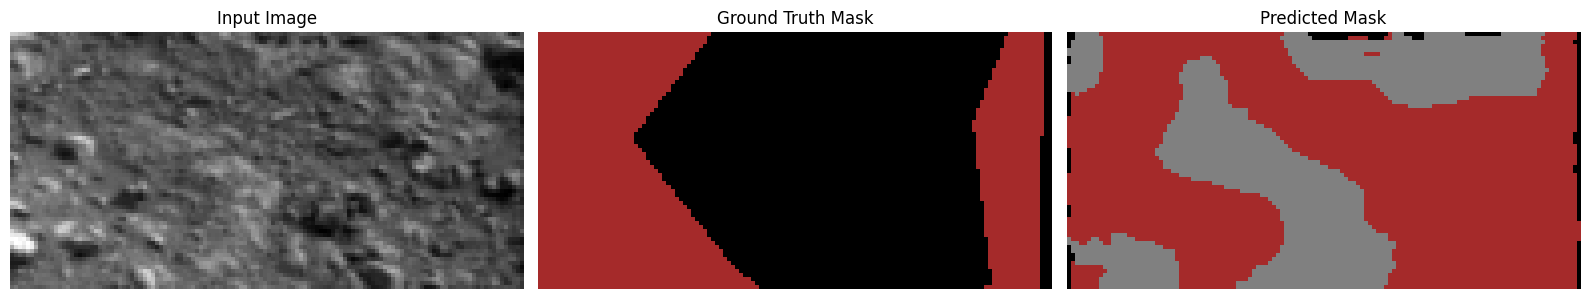

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.6905 - loss: 0.0356 - mean_intersection_over_union_3: 0.4115 - val_accuracy: 0.6253 - val_loss: 0.0434 - val_mean_intersection_over_union_3: 0.3488
Epoch 22/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7045 - loss: 0.0352 - mean_intersection_over_union_3: 0.4208 - val_accuracy: 0.7140 - val_loss: 0.0415 - val_mean_intersection_over_union_3: 0.4363
Epoch 23/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7259 - loss: 0.0347 - mean_intersection_over_union_3: 0.4413 - val_accuracy: 0.6610 - val_loss: 0.0429 - val_mean_intersection_over_union_3: 0.3898
Epoch 24/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7172 - loss: 0.0350 - mean_intersection_over_union_3: 0.4314 - val_accuracy: 0.7023 - val_loss: 0.0411 - val_mean_intersection_over_union_3: 0.4283
Epoch 25/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7274 - loss: 0.0347 - mean_intersection_over_union_3: 0.4407 - val_

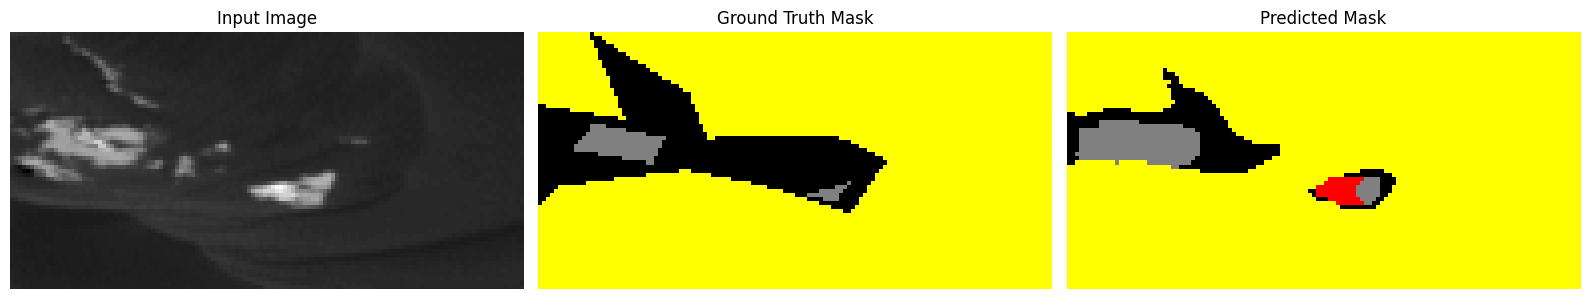

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.7424 - loss: 0.0342 - mean_intersection_over_union_3: 0.4583 - val_accuracy: 0.5903 - val_loss: 0.0449 - val_mean_intersection_over_union_3: 0.3188
Epoch 27/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7150 - loss: 0.0349 - mean_intersection_over_union_3: 0.4308 - val_accuracy: 0.6967 - val_loss: 0.0412 - val_mean_intersection_over_union_3: 0.4124
Epoch 28/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7451 - loss: 0.0341 - mean_intersection_over_union_3: 0.4592 - val_accuracy: 0.6021 - val_loss: 0.0427 - val_mean_intersection_over_union_3: 0.3426
Epoch 29/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6960 - loss: 0.0358 - mean_intersection_over_union_3: 0.4117 - val_accuracy: 0.4973 - val_loss: 0.0442 - val_mean_intersection_over_union_3: 0.2685
Epoch 30/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6613 - loss: 0.0365 - mean_intersection_over_union_3: 0.3878 - val_

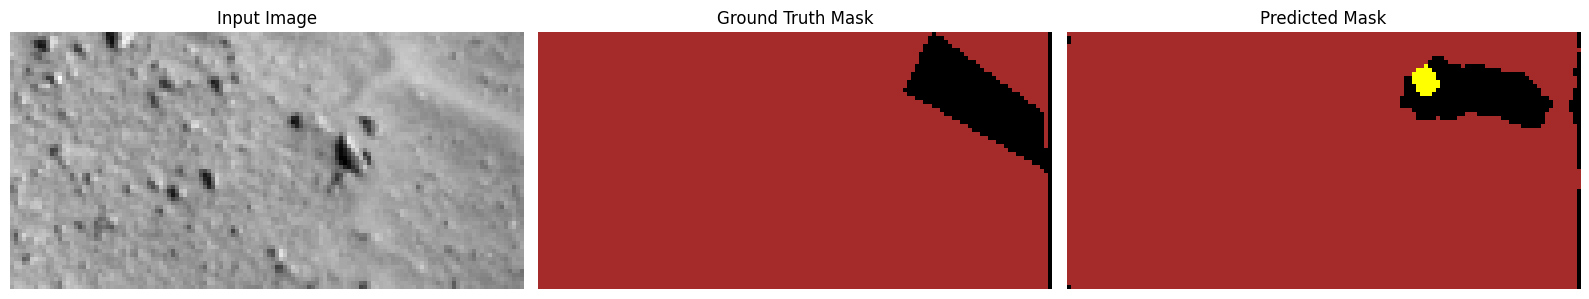

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6946 - loss: 0.0356 - mean_intersection_over_union_3: 0.4144 - val_accuracy: 0.6846 - val_loss: 0.0435 - val_mean_intersection_over_union_3: 0.4078
Epoch 32/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7318 - loss: 0.0345 - mean_intersection_over_union_3: 0.4445 - val_accuracy: 0.7233 - val_loss: 0.0414 - val_mean_intersection_over_union_3: 0.4549
Epoch 33/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7357 - loss: 0.0344 - mean_intersection_over_union_3: 0.4496 - val_accuracy: 0.4982 - val_loss: 0.0449 - val_mean_intersection_over_union_3: 0.2588
Epoch 34/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7322 - loss: 0.0344 - mean_intersection_over_union_3: 0.4446 - val_accuracy: 0.6215 - val_loss: 0.0423 - val_mean_intersection_over_union_3: 0.3510
Epoch 35/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7529 - loss: 0.0339 - mean_intersection_over_union_3: 0.4663 - val_

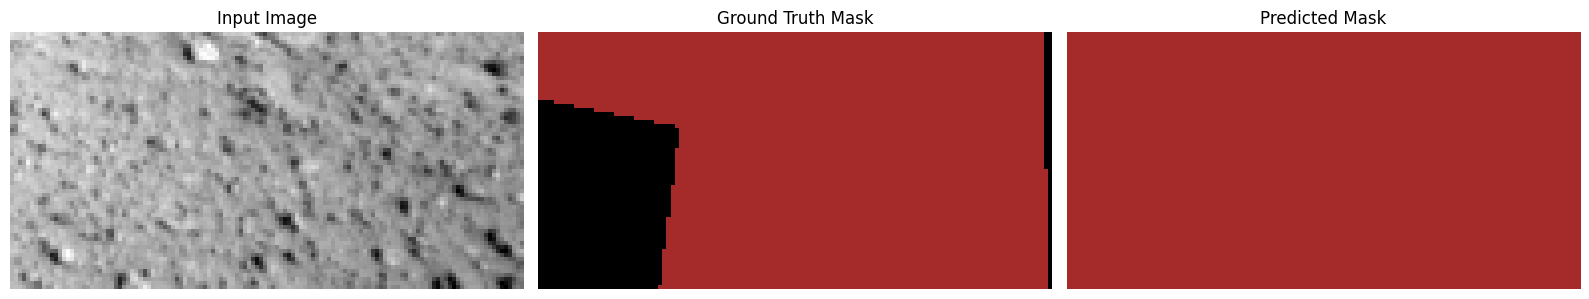

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.7505 - loss: 0.0339 - mean_intersection_over_union_3: 0.4636 - val_accuracy: 0.6899 - val_loss: 0.0410 - val_mean_intersection_over_union_3: 0.4154
Epoch 37/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7570 - loss: 0.0337 - mean_intersection_over_union_3: 0.4723 - val_accuracy: 0.4984 - val_loss: 0.0449 - val_mean_intersection_over_union_3: 0.2745
Epoch 38/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7375 - loss: 0.0342 - mean_intersection_over_union_3: 0.4505 - val_accuracy: 0.7305 - val_loss: 0.0418 - val_mean_intersection_over_union_3: 0.4598
Epoch 39/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7645 - loss: 0.0335 - mean_intersection_over_union_3: 0.4792 - val_accuracy: 0.7238 - val_loss: 0.0411 - val_mean_intersection_over_union_3: 0.4519
Epoch 40/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7697 - loss: 0.0334 - mean_intersection_over_union_3: 0.4864 - val_

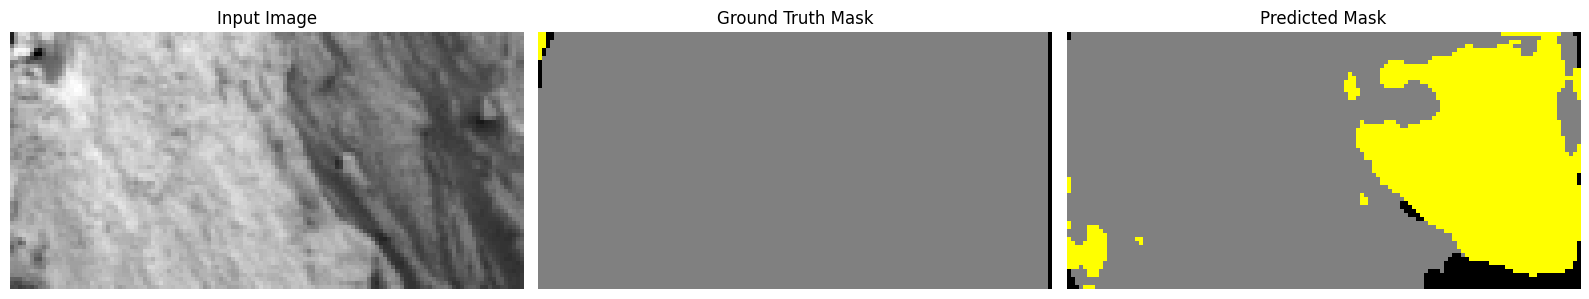

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.7650 - loss: 0.0334 - mean_intersection_over_union_3: 0.4866 - val_accuracy: 0.6548 - val_loss: 0.0430 - val_mean_intersection_over_union_3: 0.4034
Epoch 42/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7719 - loss: 0.0333 - mean_intersection_over_union_3: 0.4936 - val_accuracy: 0.6777 - val_loss: 0.0425 - val_mean_intersection_over_union_3: 0.4082
Epoch 43/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7707 - loss: 0.0334 - mean_intersection_over_union_3: 0.4859 - val_accuracy: 0.5556 - val_loss: 0.0449 - val_mean_intersection_over_union_3: 0.2949
Epoch 44/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7775 - loss: 0.0332 - mean_intersection_over_union_3: 0.5035 - val_accuracy: 0.6808 - val_loss: 0.0416 - val_mean_intersection_over_union_3: 0.4025
Epoch 45/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7700 - loss: 0.0334 - mean_intersection_over_union_3: 0.4842 - val_

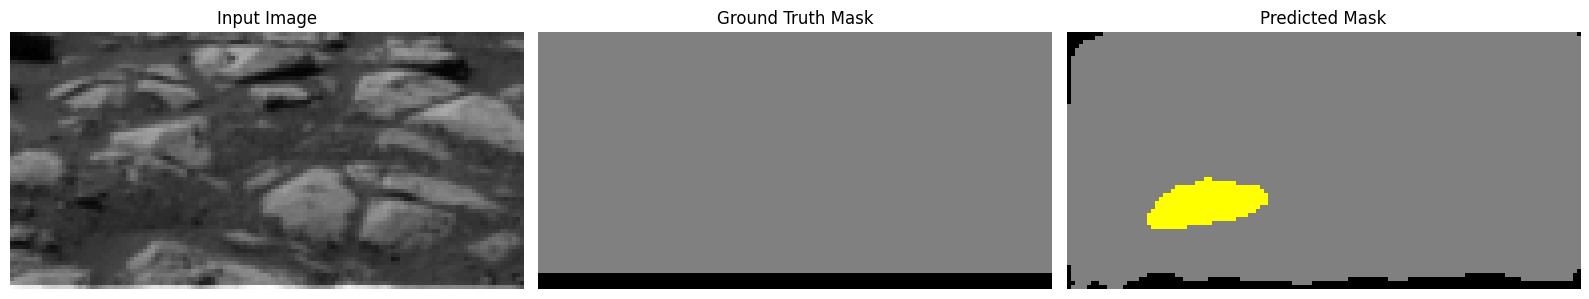

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.7720 - loss: 0.0333 - mean_intersection_over_union_3: 0.4910 - val_accuracy: 0.3507 - val_loss: 0.0524 - val_mean_intersection_over_union_3: 0.1318
Epoch 47/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7051 - loss: 0.0354 - mean_intersection_over_union_3: 0.4230 - val_accuracy: 0.6863 - val_loss: 0.0419 - val_mean_intersection_over_union_3: 0.4123
Epoch 48/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7506 - loss: 0.0339 - mean_intersection_over_union_3: 0.4574 - val_accuracy: 0.4702 - val_loss: 0.0454 - val_mean_intersection_over_union_3: 0.2320
Epoch 49/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7193 - loss: 0.0349 - mean_intersection_over_union_3: 0.4332 - val_accuracy: 0.7147 - val_loss: 0.0413 - val_mean_intersection_over_union_3: 0.4330
Epoch 50/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7675 - loss: 0.0334 - mean_intersection_over_union_3: 0.4770 - val_

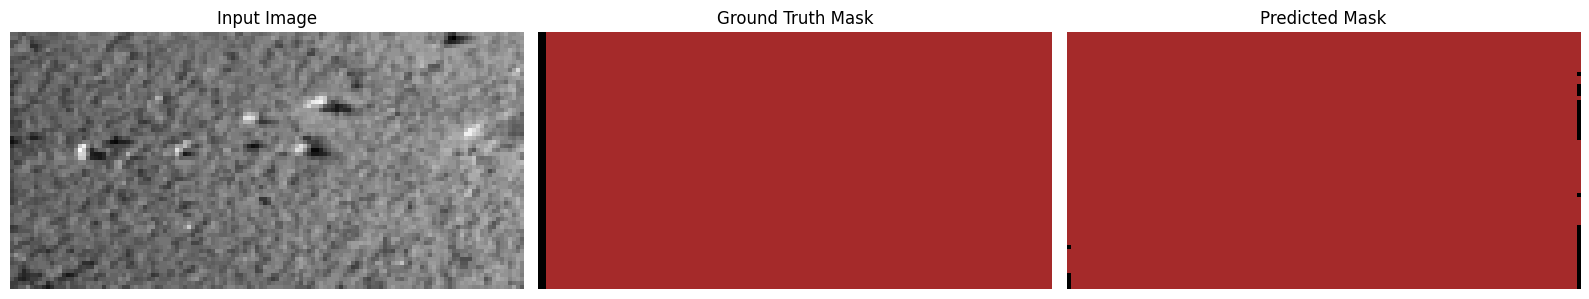

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.7856 - loss: 0.0329 - mean_intersection_over_union_3: 0.5130 - val_accuracy: 0.7254 - val_loss: 0.0423 - val_mean_intersection_over_union_3: 0.4539
Epoch 52/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7878 - loss: 0.0329 - mean_intersection_over_union_3: 0.5209 - val_accuracy: 0.6240 - val_loss: 0.0417 - val_mean_intersection_over_union_3: 0.3550
Epoch 53/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7651 - loss: 0.0334 - mean_intersection_over_union_3: 0.4734 - val_accuracy: 0.7421 - val_loss: 0.0397 - val_mean_intersection_over_union_3: 0.4596
Epoch 54/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7879 - loss: 0.0329 - mean_intersection_over_union_3: 0.4993 - val_accuracy: 0.7519 - val_loss: 0.0405 - val_mean_intersection_over_union_3: 0.4780
Epoch 55/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7917 - loss: 0.0327 - mean_intersection_over_union_3: 0.5156 - val_

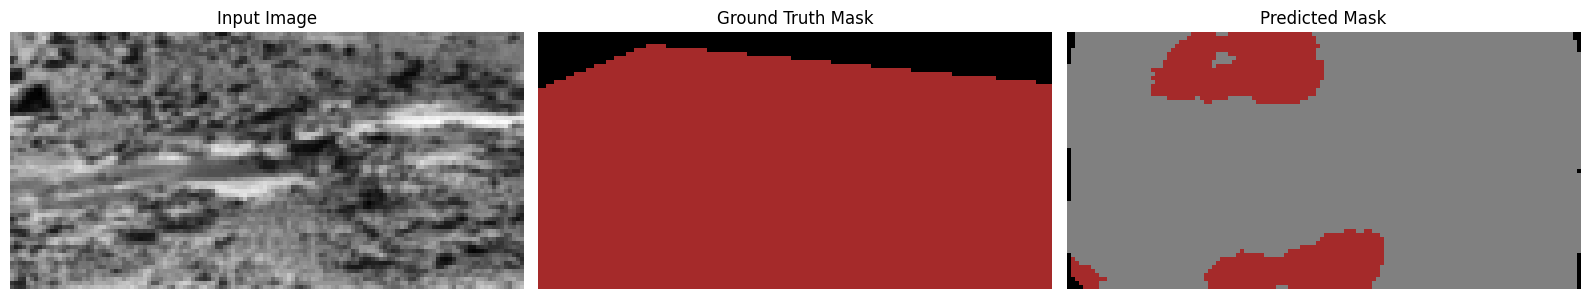

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.7828 - loss: 0.0330 - mean_intersection_over_union_3: 0.5015 - val_accuracy: 0.7305 - val_loss: 0.0418 - val_mean_intersection_over_union_3: 0.4628
Epoch 57/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7908 - loss: 0.0327 - mean_intersection_over_union_3: 0.5250 - val_accuracy: 0.7160 - val_loss: 0.0420 - val_mean_intersection_over_union_3: 0.4440
Epoch 58/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7984 - loss: 0.0326 - mean_intersection_over_union_3: 0.5372 - val_accuracy: 0.7309 - val_loss: 0.0417 - val_mean_intersection_over_union_3: 0.4679
Epoch 59/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7983 - loss: 0.0326 - mean_intersection_over_union_3: 0.5457 - val_accuracy: 0.7128 - val_loss: 0.0411 - val_mean_intersection_over_union_3: 0.4367
Epoch 60/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7957 - loss: 0.0326 - mean_intersection_over_union_3: 0.5145 - val_

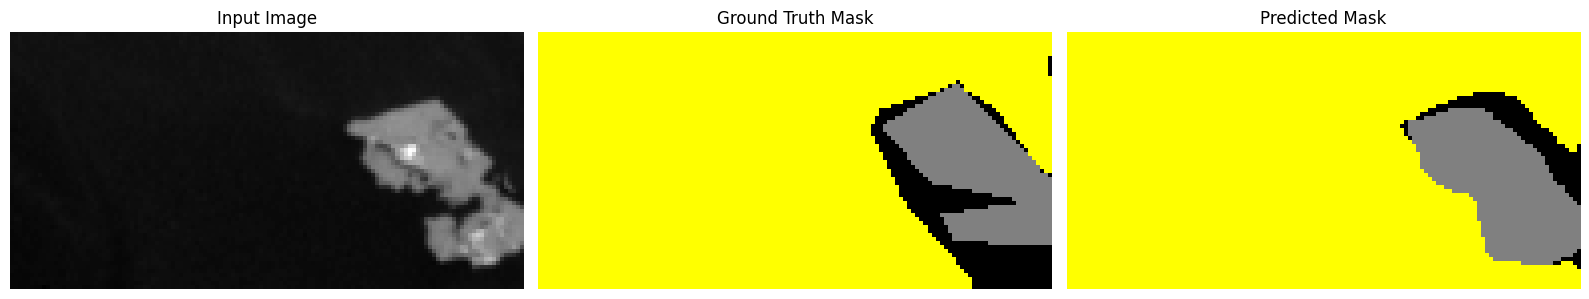

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8047 - loss: 0.0324 - mean_intersection_over_union_3: 0.5457 - val_accuracy: 0.7352 - val_loss: 0.0406 - val_mean_intersection_over_union_3: 0.4620
Epoch 62/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8076 - loss: 0.0323 - mean_intersection_over_union_3: 0.5414 - val_accuracy: 0.6866 - val_loss: 0.0434 - val_mean_intersection_over_union_3: 0.4046
Epoch 63/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7948 - loss: 0.0326 - mean_intersection_over_union_3: 0.5041 - val_accuracy: 0.6253 - val_loss: 0.0448 - val_mean_intersection_over_union_3: 0.3625
Epoch 64/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7816 - loss: 0.0330 - mean_intersection_over_union_3: 0.4835 - val_accuracy: 0.7530 - val_loss: 0.0404 - val_mean_intersection_over_union_3: 0.4747
Epoch 65/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8106 - loss: 0.0322 - mean_intersection_over_union_3: 0.5403 - val_

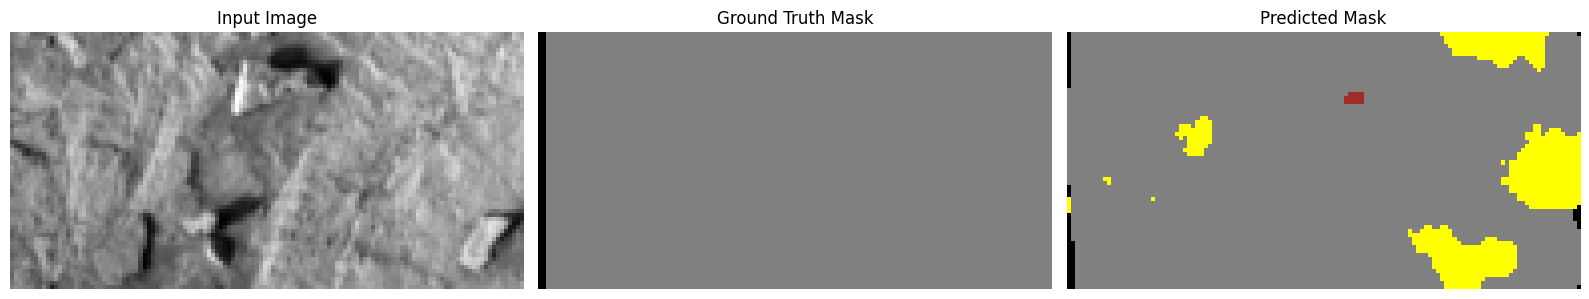

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8151 - loss: 0.0321 - mean_intersection_over_union_3: 0.5428 - val_accuracy: 0.7010 - val_loss: 0.0412 - val_mean_intersection_over_union_3: 0.4152
Epoch 67/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8154 - loss: 0.0321 - mean_intersection_over_union_3: 0.5431 - val_accuracy: 0.7678 - val_loss: 0.0412 - val_mean_intersection_over_union_3: 0.4956
Epoch 68/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8212 - loss: 0.0320 - mean_intersection_over_union_3: 0.5689 - val_accuracy: 0.7660 - val_loss: 0.0419 - val_mean_intersection_over_union_3: 0.4897
Epoch 69/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8189 - loss: 0.0320 - mean_intersection_over_union_3: 0.5711 - val_accuracy: 0.7131 - val_loss: 0.0395 - val_mean_intersection_over_union_3: 0.4403
Epoch 70/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8156 - loss: 0.0321 - mean_intersection_over_union_3: 0.5405 - val_

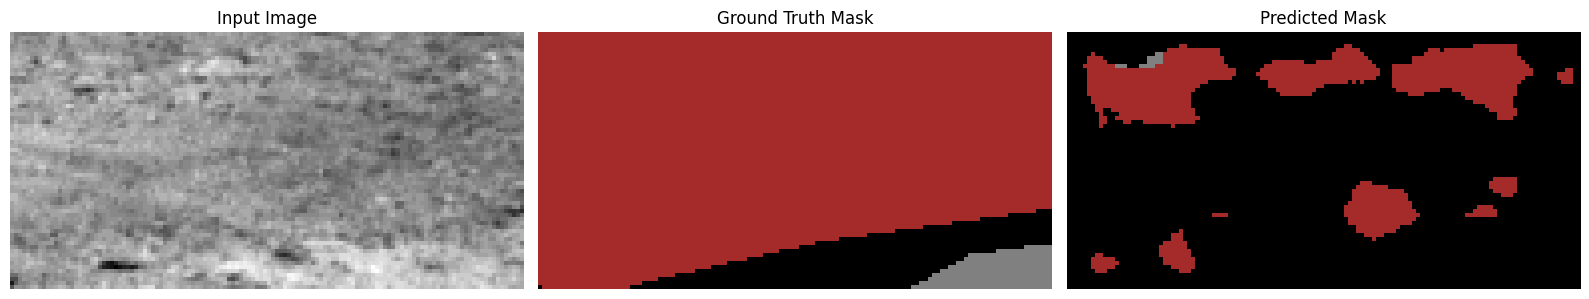

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8308 - loss: 0.0317 - mean_intersection_over_union_3: 0.5995 - val_accuracy: 0.6577 - val_loss: 0.0423 - val_mean_intersection_over_union_3: 0.3682
Epoch 72/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8046 - loss: 0.0324 - mean_intersection_over_union_3: 0.5146 - val_accuracy: 0.7411 - val_loss: 0.0411 - val_mean_intersection_over_union_3: 0.4736
Epoch 73/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8252 - loss: 0.0319 - mean_intersection_over_union_3: 0.5547 - val_accuracy: 0.7427 - val_loss: 0.0426 - val_mean_intersection_over_union_3: 0.4703
Epoch 74/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8263 - loss: 0.0318 - mean_intersection_over_union_3: 0.5733 - val_accuracy: 0.7385 - val_loss: 0.0424 - val_mean_intersection_over_union_3: 0.4669
Epoch 75/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8327 - loss: 0.0317 - mean_intersection_over_union_3: 0.5926 - val_

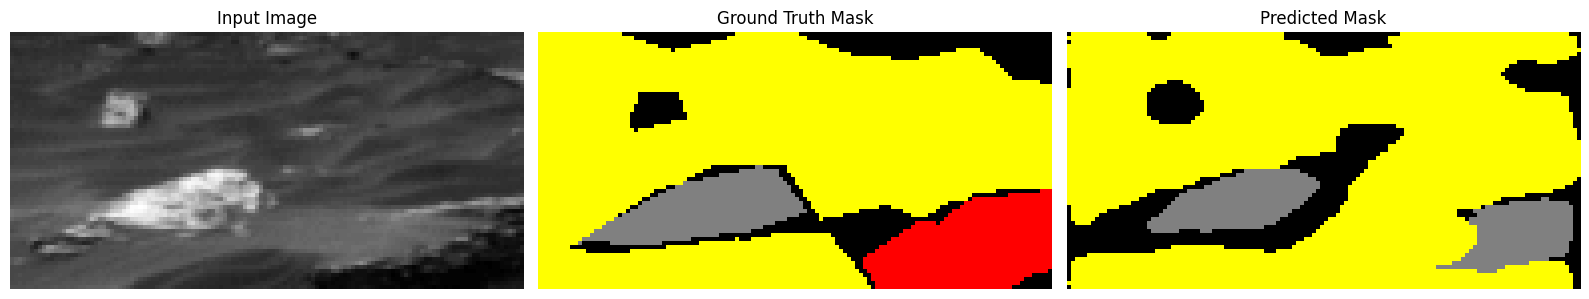

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8287 - loss: 0.0318 - mean_intersection_over_union_3: 0.5523 - val_accuracy: 0.7305 - val_loss: 0.0418 - val_mean_intersection_over_union_3: 0.4669
Epoch 77/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8266 - loss: 0.0319 - mean_intersection_over_union_3: 0.5541 - val_accuracy: 0.7588 - val_loss: 0.0415 - val_mean_intersection_over_union_3: 0.5001
Epoch 78/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8225 - loss: 0.0320 - mean_intersection_over_union_3: 0.5407 - val_accuracy: 0.6560 - val_loss: 0.0411 - val_mean_intersection_over_union_3: 0.3794
Epoch 79/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7933 - loss: 0.0328 - mean_intersection_over_union_3: 0.4897 - val_accuracy: 0.7691 - val_loss: 0.0417 - val_mean_intersection_over_union_3: 0.5092
Epoch 80/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8334 - loss: 0.0316 - mean_intersection_over_union_3: 0.5779 - val_

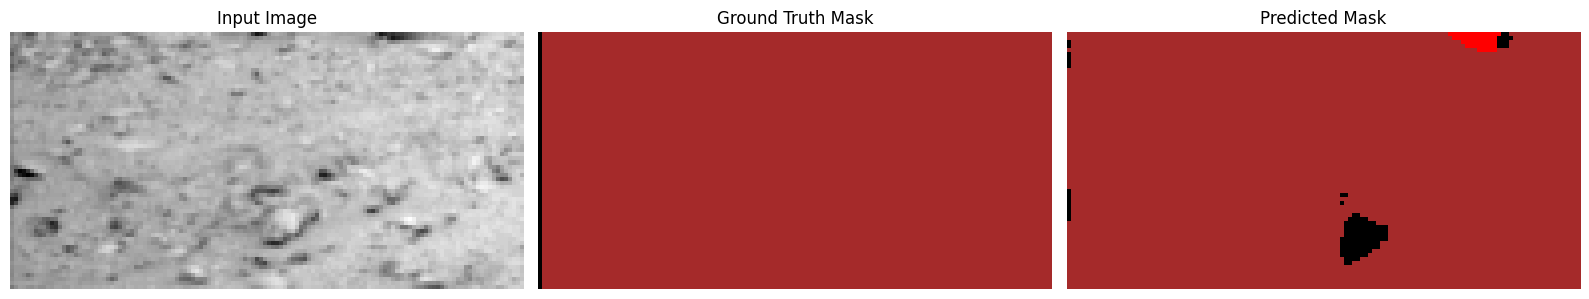

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.8415 - loss: 0.0314 - mean_intersection_over_union_3: 0.5817 - val_accuracy: 0.7582 - val_loss: 0.0418 - val_mean_intersection_over_union_3: 0.4925
Epoch 82/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8483 - loss: 0.0313 - mean_intersection_over_union_3: 0.6051 - val_accuracy: 0.7358 - val_loss: 0.0406 - val_mean_intersection_over_union_3: 0.4568
Epoch 83/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8501 - loss: 0.0312 - mean_intersection_over_union_3: 0.6029 - val_accuracy: 0.7091 - val_loss: 0.0423 - val_mean_intersection_over_union_3: 0.4403
Epoch 84/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8514 - loss: 0.0312 - mean_intersection_over_union_3: 0.6150 - val_accuracy: 0.7462 - val_loss: 0.0422 - val_mean_intersection_over_union_3: 0.4875
Epoch 85/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8563 - loss: 0.0311 - mean_intersection_over_union_3: 0.6310 - val_

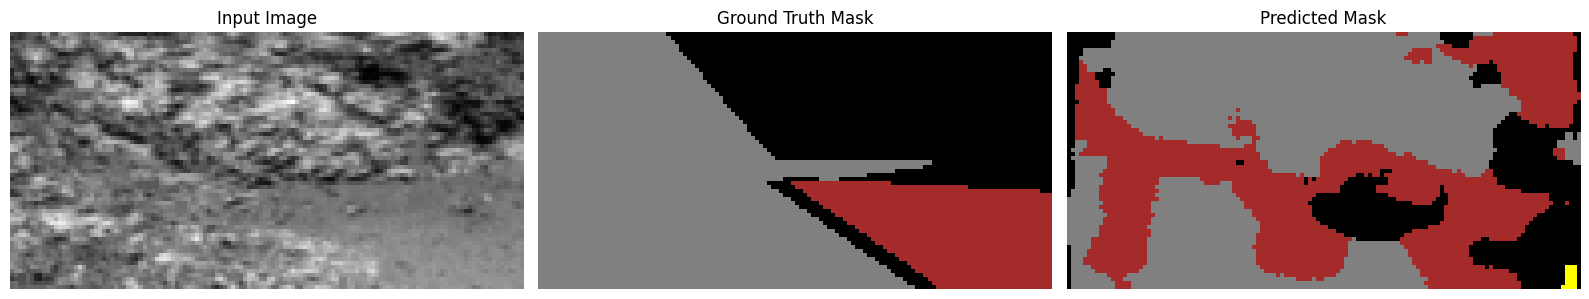

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8519 - loss: 0.0312 - mean_intersection_over_union_3: 0.6021 - val_accuracy: 0.7251 - val_loss: 0.0427 - val_mean_intersection_over_union_3: 0.4620
Epoch 87/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8560 - loss: 0.0311 - mean_intersection_over_union_3: 0.6319 - val_accuracy: 0.7468 - val_loss: 0.0418 - val_mean_intersection_over_union_3: 0.4831
Epoch 88/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8619 - loss: 0.0309 - mean_intersection_over_union_3: 0.6344 - val_accuracy: 0.7394 - val_loss: 0.0424 - val_mean_intersection_over_union_3: 0.4789
Epoch 89/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8584 - loss: 0.0310 - mean_intersection_over_union_3: 0.6331 - val_accuracy: 0.7447 - val_loss: 0.0422 - val_mean_intersection_over_union_3: 0.4780
Epoch 90/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8562 - loss: 0.0311 - mean_intersection_over_union_3: 0.6105 - val_

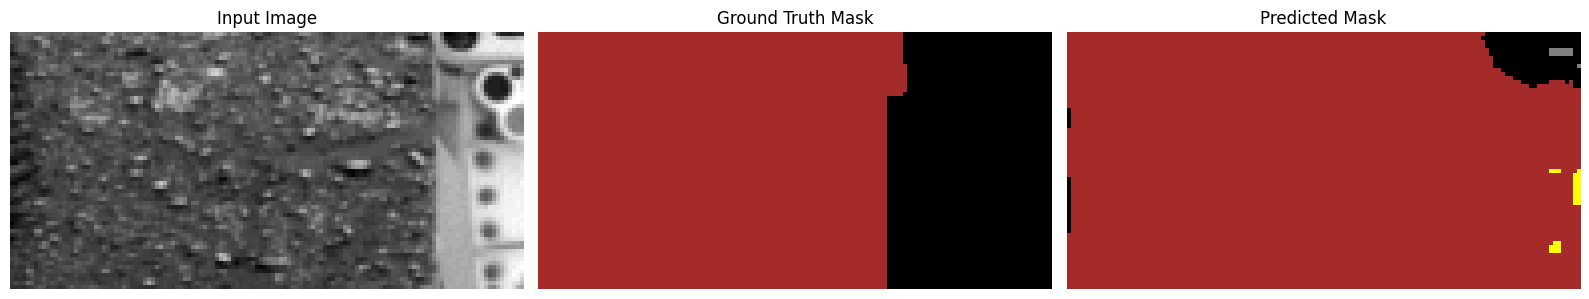

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8473 - loss: 0.0313 - mean_intersection_over_union_3: 0.5892 - val_accuracy: 0.7524 - val_loss: 0.0420 - val_mean_intersection_over_union_3: 0.4829
Epoch 92/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8610 - loss: 0.0309 - mean_intersection_over_union_3: 0.6141 - val_accuracy: 0.7442 - val_loss: 0.0417 - val_mean_intersection_over_union_3: 0.4851
Epoch 93/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8702 - loss: 0.0307 - mean_intersection_over_union_3: 0.6490 - val_accuracy: 0.7262 - val_loss: 0.0426 - val_mean_intersection_over_union_3: 0.4611
Epoch 94/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8728 - loss: 0.0306 - mean_intersection_over_union_3: 0.6687 - val_accuracy: 0.7547 - val_loss: 0.0425 - val_mean_intersection_over_union_3: 0.4812
Epoch 95/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8668 - loss: 0.0308 - mean_intersection_over_union_3: 0.6343 - val_

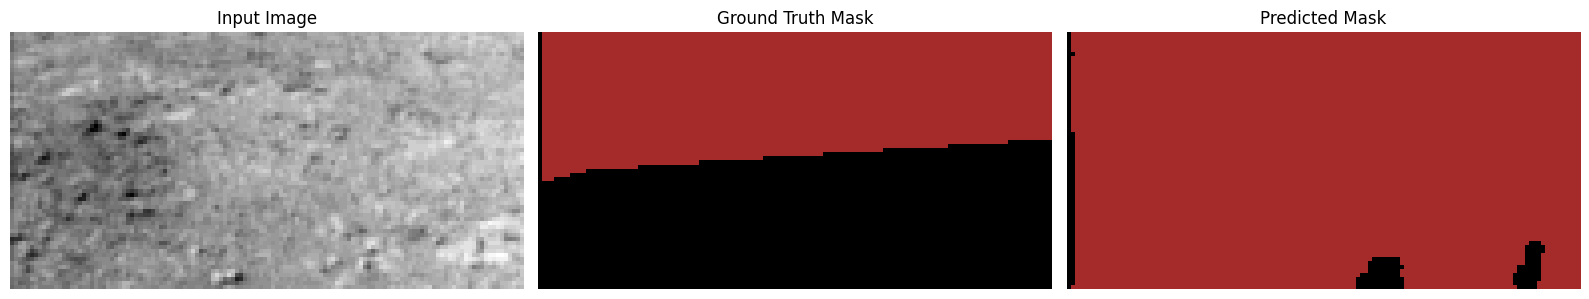

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8618 - loss: 0.0309 - mean_intersection_over_union_3: 0.6143 - val_accuracy: 0.7444 - val_loss: 0.0413 - val_mean_intersection_over_union_3: 0.4875
Epoch 97/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8621 - loss: 0.0309 - mean_intersection_over_union_3: 0.5909 - val_accuracy: 0.7667 - val_loss: 0.0416 - val_mean_intersection_over_union_3: 0.5183
Epoch 98/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8718 - loss: 0.0307 - mean_intersection_over_union_3: 0.6190 - val_accuracy: 0.7362 - val_loss: 0.0413 - val_mean_intersection_over_union_3: 0.4669
Epoch 99/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8740 - loss: 0.0306 - mean_intersection_over_union_3: 0.6213 - val_accuracy: 0.7492 - val_loss: 0.0413 - val_mean_intersection_over_union_3: 0.4816
Epoch 100/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8559 - loss: 0.0311 - mean_intersection_over_union_3: 0.5772 - val

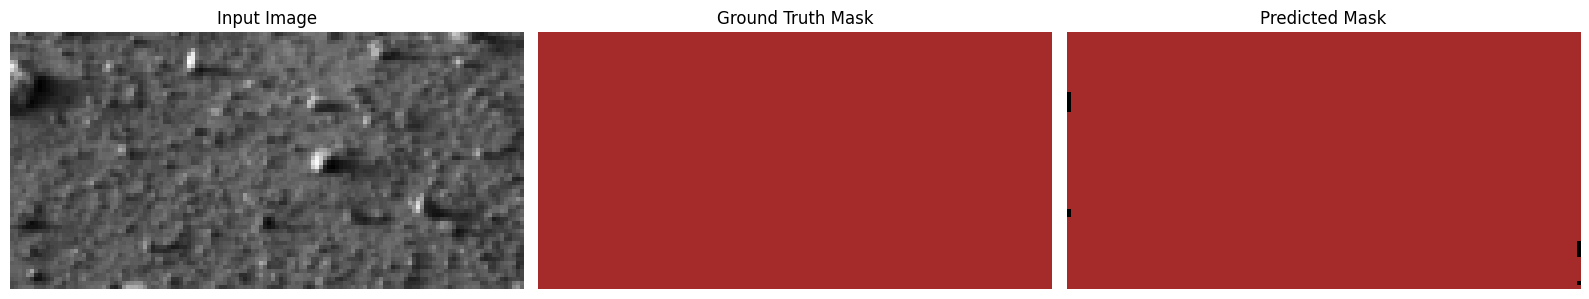

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.8654 - loss: 0.0308 - mean_intersection_over_union_3: 0.5842 - val_accuracy: 0.7663 - val_loss: 0.0415 - val_mean_intersection_over_union_3: 0.5136
Epoch 102/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8795 - loss: 0.0305 - mean_intersection_over_union_3: 0.6497 - val_accuracy: 0.7506 - val_loss: 0.0412 - val_mean_intersection_over_union_3: 0.4891
Epoch 103/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8821 - loss: 0.0304 - mean_intersection_over_union_3: 0.6560 - val_accuracy: 0.7724 - val_loss: 0.0415 - val_mean_intersection_over_union_3: 0.5193
Epoch 104/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8850 - loss: 0.0303 - mean_intersection_over_union_3: 0.6737 - val_accuracy: 0.7432 - val_loss: 0.0418 - val_mean_intersection_over_union_3: 0.4877
Epoch 105/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8864 - loss: 0.0303 - mean_intersection_over_union_3: 0.6748 - 

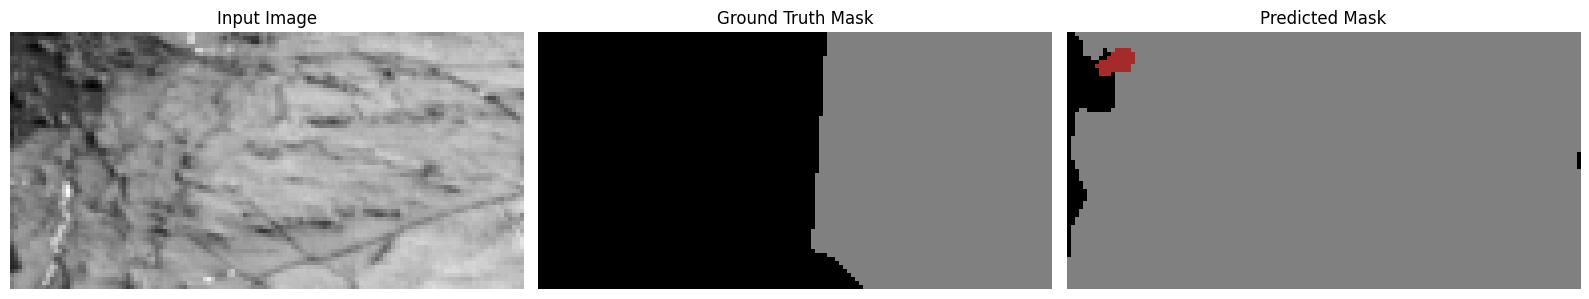

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8779 - loss: 0.0305 - mean_intersection_over_union_3: 0.6361 - val_accuracy: 0.7670 - val_loss: 0.0416 - val_mean_intersection_over_union_3: 0.5153
Epoch 107/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8886 - loss: 0.0302 - mean_intersection_over_union_3: 0.6829 - val_accuracy: 0.7385 - val_loss: 0.0418 - val_mean_intersection_over_union_3: 0.4855
Epoch 108/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8915 - loss: 0.0301 - mean_intersection_over_union_3: 0.6851 - val_accuracy: 0.7553 - val_loss: 0.0417 - val_mean_intersection_over_union_3: 0.5014
Epoch 109/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8901 - loss: 0.0302 - mean_intersection_over_union_3: 0.6849 - val_accuracy: 0.7433 - val_loss: 0.0419 - val_mean_intersection_over_union_3: 0.4913
Epoch 110/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8914 - loss: 0.0301 - mean_intersection_over_union_3: 0.6921 - 

In [ ]:
from matplotlib.colors import ListedColormap


# Train the model
history = model.fit(
    X_train_augmented,
    y_train_augmented,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, viz_callback],
    verbose=1
)

final_val_meanIoU = round(max(history.history['val_mean_intersection_over_union_3']) * 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

model_filename = f'UNet_valIoU{final_val_meanIoU}.keras'
model.save(model_filename)

del model


In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_valIoU52.32.keras


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Crea il file CSV nella directory di lavoro di Kaggle
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"/kaggle/working/submission_{timestep_str}.csv"
submission_df = y_to_df(preds)  # Conversione predizioni in dataframe
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file saved as: {submission_filename}")

Submission file saved as: /kaggle/working/submission_UNet_valIoU52.32.csv
